# Введение в обработку естественного языка

## Урок 4. Тематическое моделирование. EM-алгоритм

In [1]:
import warnings

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from corus import load_lenta
import nltk
from gensim import corpora
from gensim.models import ldamodel, CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

### Данные lenta.ru

Загружены отсюда: https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz

In [3]:
DATA_PATH = '../data/lenta-ru-news.csv.gz'

In [4]:
%%time
try:
    assert data is not None
except NameError:
    records = load_lenta(DATA_PATH)
    record_data = ((record.title, record.topic, record.text, record.tags) for record in records)
    data = pd.DataFrame(record_data, columns=['title','topic','text','tags']).dropna()

Wall time: 54.1 s


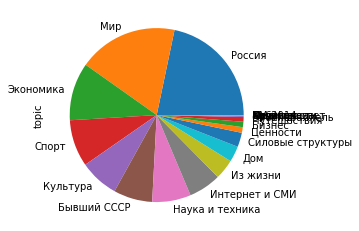

In [35]:
# Распределение по темам в датасете
data.topic.value_counts().plot.pie();

In [38]:
# Выберем 4 большие темы, и из каждой темы случайным образом выберем 3000 документов
topics = ['Экономика', 'Спорт', 'Культура', 'Наука и техника']
df = (
    data[data.topic.isin(topics)]
    .filter(['topic', 'text'])
    .rename(columns={'text': 'text_orig'})
    .groupby('topic')
    .sample(3000, random_state=101)
)
df.shape

(12000, 2)

### Предобработка с помощью Natasha

In [40]:
warnings.simplefilter(action='ignore')
from natasha import Doc, Segmenter, NewsEmbedding, NewsMorphTagger, MorphVocab
segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
morph_vocab = MorphVocab()

In [41]:
custom_stopwords = ['год', 'лента', 'ру']
stopwords = (
    set(nltk.corpus.stopwords.words("english")) |
    set(nltk.corpus.stopwords.words("russian")) |
    set(custom_stopwords)
)

Лемматизация выполняется несколько быстрее, если
- объединить все тексты в один (с разделителем документов)
- воспользоваться возможностями морфологического разбора и оставлять только отдельные части речи

In [42]:
df_speed = df  # df[:500]  # на этапе отладки

In [43]:
%%time
SEP = '🛑'
all_text = f"\n{SEP}\n".join(df_speed['text_orig'].str.replace(SEP, ''))
doc = Doc(all_text)
doc.segment(segmenter)
doc.tag_morph(morph_tagger)

Wall time: 9min 15s


In [44]:
%%time
allow_pos = {'NOUN', 'PROPN', 'VERB', 'X'}
all_docs = []
current_doc = []

for tok in tqdm(doc.tokens):
    if tok.text == SEP:
        all_docs.append(current_doc)
        current_doc = []
    elif len(tok.text) > 1 and tok.pos in allow_pos:
        tok.lemmatize(morph_vocab)
        if tok.lemma not in stopwords:
            current_doc.append(tok.lemma)

all_docs.append(current_doc)
current_doc = []
df_speed['text'] = all_docs

  0%|          | 0/2602293 [00:00<?, ?it/s]

Wall time: 3min 23s


In [45]:
df_speed.to_pickle('../data/lenta_lemmatized.pickle.gz')

In [46]:
df = pd.read_pickle('../data/lenta_lemmatized.pickle.gz')

### Модель LDA

In [47]:
dictionary = corpora.Dictionary(df['text'])
dictionary.filter_extremes(no_below = 5, no_above = 0.9)
corpus = [dictionary.doc2bow(text) for text in df['text']]

In [48]:
%%time
# Выбор количества тем по когерентности
lda_model = {}
num_topics_grid = list(range(2, 12))
coherences = []

for num in tqdm(num_topics_grid):
    lda_model[num] = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherence_model = CoherenceModel(model=lda_model[num], texts=df['text'], dictionary=dictionary, coherence='c_v')
    coherences.append(coherence_model.get_coherence())

  0%|          | 0/10 [00:00<?, ?it/s]

Wall time: 9min 56s


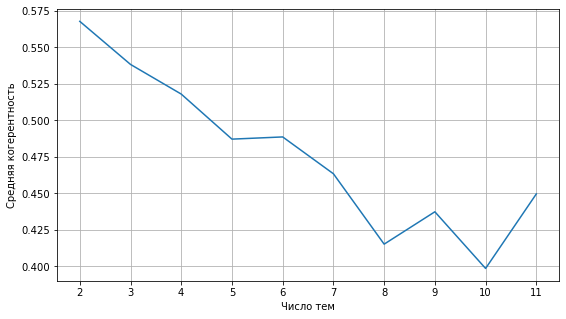

In [22]:
plt.figure(figsize=(9,5))
plt.xticks(num_topics_grid)
plt.grid()

plt.plot(num_topics_grid, coherences)

plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

Надо сказать, что график не всегда такой. Бывает, что максимум наблюдается на двух темах, затем локальный максимум пониже - на 4-6 темах.

In [53]:
# Выберем модель с num_topics=6
lda = lda_model[6]
lda.log_perplexity(corpus)

-8.755064008360444

In [54]:
%%time
# Посмотрим визуализацию
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

Wall time: 6.69 s


### Сравнение ручной классификации и LDA

In [90]:
# Дадим условные названия выделенным темам, исходя из визуализации, по сочетанию преобладающих токенов
lda_topic_desc = {
    0: '«Действие»',
    1: '«Мир»',
    2: '«Политика»',
    3: '«Бизнес»',
    4: '«Богатство»',
    5: '«Соревнование»'
}

In [56]:
%%time
lda_topic = []
for text in tqdm(df['text']):
    bow = dictionary.doc2bow(text)
    t = lda.get_document_topics(bow)
    lda_topic.append(max(t, key=lambda x: x[1])[0])

  0%|          | 0/12000 [00:00<?, ?it/s]

Wall time: 9.73 s


In [91]:
df['lda_topic'] = pd.Series(lda_topic).map(lda_topic_desc).values

In [92]:
pd.crosstab(df['lda_topic'], df['topic']).style.background_gradient(cmap='Blues')

topic,Культура,Наука и техника,Спорт,Экономика
lda_topic,,,,
«Бизнес»,1218,47,1703,3
«Богатство»,475,350,430,9
«Действие»,320,1974,132,294
«Мир»,63,323,14,1544
«Политика»,519,66,116,436
«Соревнование»,405,240,605,714


Тема науки и техники связана со словами, в которых угадывается развитие (главное слово - "мочь"). Экономика преобладает международная. В теме "Спорт", если верить данному тематическому моделированию, на первом месте совсем не соревнования, а коммерческие аспекты, так же как и для темы "Культура". Одна lda-тема, вероятно, лишняя, так как в ней мало документов и они равномерно размазаны по "ручным" темам.



В целом, я бы не назвал данное тематическое моделирование особо удачным, но по возможности хотелось бы получить обратную связь, чтобы понимать, в какую сторону двигаться, чтобы его улучшить.